# General goals
1. Reading and loading data
```
read_edf
    Args:
        path(str): 
    Returns:
        raw: matrix of (n_channel, n_sample)
        sampling_rate(int): in Hz
        channel_names: list of channel names



segmentize(raw, seg_window=1):
    Segmentize raw data into list of epochs.
    Args:
        raw: (n_channel, n_sample)
        seg_window: window size of resulting epoch.
```            
2. Pre-processing
    * segmentation
        return data of the same size.
        Args: 
            chunk: 
For each edf file, we cannot assume the first channel is always the same physical location of electrode. 
1. Set some standard label and order.
Ideally I can use data.frame, however I will first see what format others used. The order can be arbitrary, but I will see what other used first.
2. Read edf file and its montage, 
This can be done using the aforementioned functions from pystream
3. Convert edf reading to standard format.
This can be done using numpy and panda
4. Chop seizure
Comparing the sampling rate, time and annotated time, we extract some chunks of seizure signal.
5. Chop pre-ictal 
Chop from 10 to 20 seconds preceding seizures.
6. Chop background
10 minutes preceding seizures and 10 minutes after seizures. 

## EDA

In [1]:
from file_io import * 
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

In [2]:
# relabeling config
LEN_PRE = 15
LEN_POS = 60
SEC_GAP = 0

In [3]:
train_path = '../tusz_1_5_2/edf/train'
tcp_type = '01_tcp_ar'
patient_group = '004'
patient = '00000492'
session = 's003_2003_07_18'
token = '00000492_s003_t001'

In [17]:
tokens_bucket = []  # list of statistics to explore in between tokens.


In [5]:
def preprocess(edf_path_no_extension:str):
    f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
    # sort channel label
    s = sort_channel(s, l, STD_CHANNEL_01_AR)
    f = int(np.mean(f))
    intvs, labls = load_tse_bi(tf)
    intvs, labls = relabel_tse_bi(intvs=intvs, labels=labls, len_pre=LEN_PRE, len_post=LEN_POS, sec_gap=SEC_GAP)
    ds, lbl = signal_to_dataset(sig=s, fsamp=f, intvs=intvs, labels=labls)
    return ds, lbl

f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))

#TODO: 1 should be np.array
s = np.array(s)
s.shape

(22, 73600)

In [26]:
df = pd.DataFrame(s.transpose(), columns=["ch"+str(i) for i in range(0, 22)])

### 1 channel

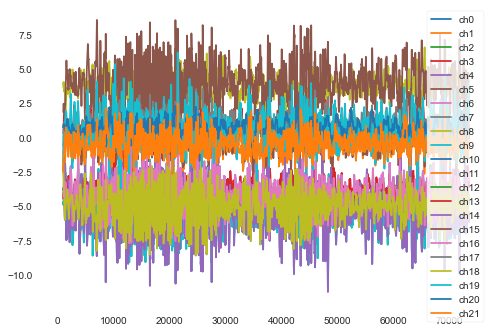

In [42]:
df\
.iloc[:,:]\
.rolling(1000)\
.mean()\
.plot()

#### Preprocess-1: Remove DC Offset

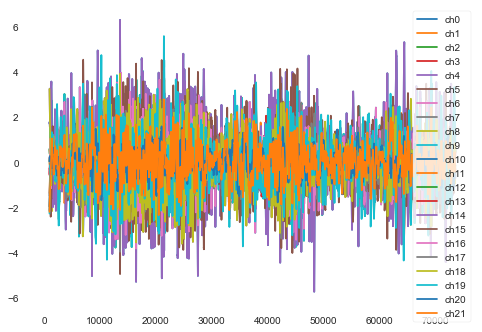

In [52]:
def remove_dc_offset(df:pd.DataFrame):
    return(df.apply(lambda x: x - np.mean(x)))

df.apply(lambda x: x - np.mean(x)).rolling(1000).mean().plot()

In [54]:
#TODO: baseline drift is negligible?


### channels
statistics of each channels and their correlation

In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True, explorative=True)

profile.to_notebook_iframe()

##### Summary statistics

In [10]:
channels_stats = df.describe()\
    .append(df.skew().rename('skew'))\
    .append(df.kurtosis().rename('kurt'))

##### Correlation

In [14]:
import matplotlib.pyplot as plt
def plot_corrmat(corrmat):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(corrmat, fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

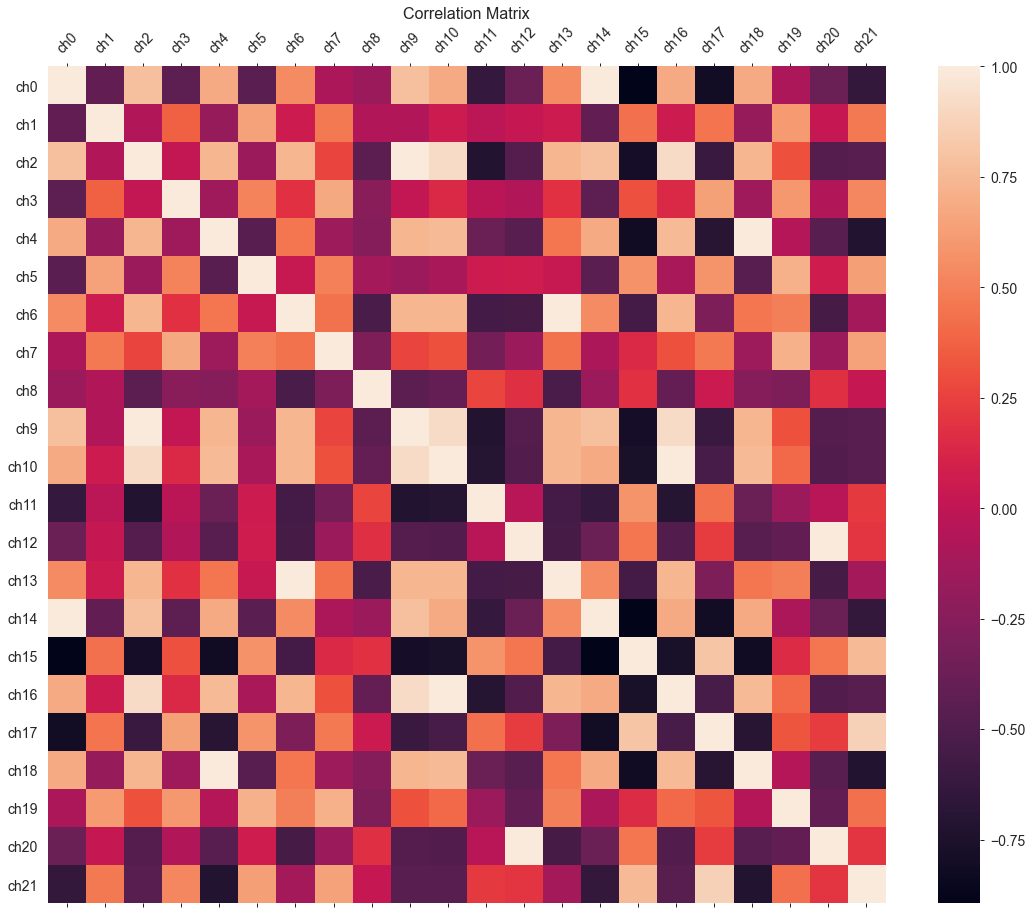

In [58]:
channels_corrmat = df.corr()
plot_corrmat(channels_corrmat)
# eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)

It seems many channels are strongly correlated with each other. We will first double check if such correlation is ubiquitous thoughout different sessions, different patients. 

In [18]:
tokens_bucket.append("corrmat")

### tokens

load one session of a patient

In [219]:
session_path = os.path.join(train_path, tcp_type, patient_group, patient, session)

token_files = [os.path.join(session_path, f[:-4]) for f in os.listdir(
    session_path) if f.endswith('.edf')]

dataset, labels = [], []
for tf in token_files:
    f, s, l = read_1_token(tf)
    # sort channel label
    s = sort_channel(s, l, STD_CHANNEL_01_AR)
    f = int(np.mean(f))
    intvs, labls = load_tse_bi(tf)
    intvs, labls = relabel_tse_bi(intvs=intvs, labels=labls, len_pre=LEN_PRE, len_post=LEN_POS, sec_gap=SEC_GAP)
    ds, lbl = signal_to_dataset(sig=s, fsamp=f, intvs=intvs, labels=labls)
    dataset.extend(ds)
    labels.extend(lbl)
    
np.shape(dataset), np.shape(labels)

((2013, 22, 400), (2013,))

sampling rate (Hz)

In [220]:
fsamp = f; fsamp
id_bkg_pre = [any([yi == lbl for lbl in [LABEL_BKG, LABEL_PRE]]) for yi in labels]
id_pre = [any([yi == lbl for lbl in [LABEL_PRE]]) for yi in labels]
id_bkg = [any([yi == lbl for lbl in [LABEL_BKG]]) for yi in labels]


## Visualize sample EEG traces

In [221]:
find_label = lambda l, v: [i for i,x in enumerate(l) if x==v]

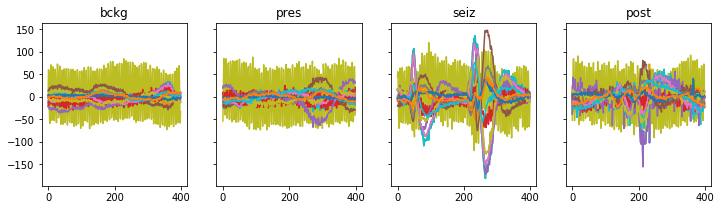

In [224]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)

ishows = [find_label(labels, lbl)[1]-1 for lbl in [LABEL_BKG, LABEL_PRE, LABEL_SEZ, LABEL_POS]]

for i, ax in enumerate(axes.flat):
    pd.DataFrame(np.transpose(dataset[ishows[i]])).plot(ax=ax, legend=False)
    ax.set_title(labels[ishows[i]])

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-21.604734,-21.604734,-23.404295,-24.304075,-27.903198,-27.903198,-25.203856,-25.203856,-25.203856,-27.003417,...,-5.408683,-6.308464,-4.508903,-0.909781,1.789561,-0.010000,-3.609122,-3.609122,-5.408683,-4.508903
1,8.997806,8.098025,8.997806,8.997806,8.997806,9.897586,8.997806,8.997806,8.997806,8.098025,...,-0.899781,-1.799561,-1.799561,-0.899781,-2.699342,-1.799561,0.000000,0.000000,0.899781,1.799561
2,-9.007806,-8.108025,-10.807367,-13.506709,-13.506709,-12.606928,-14.406489,-12.606928,-14.406489,-14.406489,...,-6.308464,-5.408683,-5.408683,-4.508903,-3.609122,-4.508903,-7.208245,-8.108025,-10.807367,-9.907586
3,3.599122,4.498903,4.498903,5.398683,2.699342,3.599122,6.298464,5.398683,3.599122,4.498903,...,4.498903,5.398683,5.398683,6.298464,4.498903,5.398683,4.498903,2.699342,4.498903,5.398683
4,-1.809561,-0.909781,-1.809561,-6.308464,-7.208245,-7.208245,-8.108025,-6.308464,-6.308464,-7.208245,...,-12.606928,-12.606928,-10.807367,-9.007806,-7.208245,-7.208245,-9.007806,-9.907586,-13.506709,-12.606928


## Power spectra features

In [225]:
import feature as ft
import seaborn as sb


def explore1D(new_ds, title=''):
    sb.stripplot(x='x', y='y', data=pd.DataFrame().assign(x=new_ds, y=labels))
    plt.title(title)
    
    
def explore2D(ds, labels, title=''):
    """
    ds: nepochs x nchannels x nsamples
    """
    _, axes = plt.subplots(nrows=22, ncols=4, figsize=(15, 50))
    arranges = (LABEL_BKG, LABEL_PRE, LABEL_SEZ, LABEL_POS, LABEL_NAN)
    for i, epoch in enumerate(ds):
        icol = arranges.index(labels[i])
        for ic, channel in enumerate(epoch):
            axes[ic][icol].plot(channel)

### PyEEG 

In [226]:
import pyeeg
locate = lambda listOfElems, elem: [ i for i in range(len(listOfElems)) if listOfElems[i] == elem ]

plt.plot()

In [227]:
dataset_power = []
for i, data in enumerate(dataset):
    res = []
    for j, channel in enumerate(data):
        power = pyeeg.bin_power(channel, Band=range(0, 45), Fs=fsamp)[0]
        res.append(power)
    dataset_power.append(res)
np.shape(dataset_power)   

(2013, 22, 44)

In [228]:
ds_pwd = np.array(dataset_power)

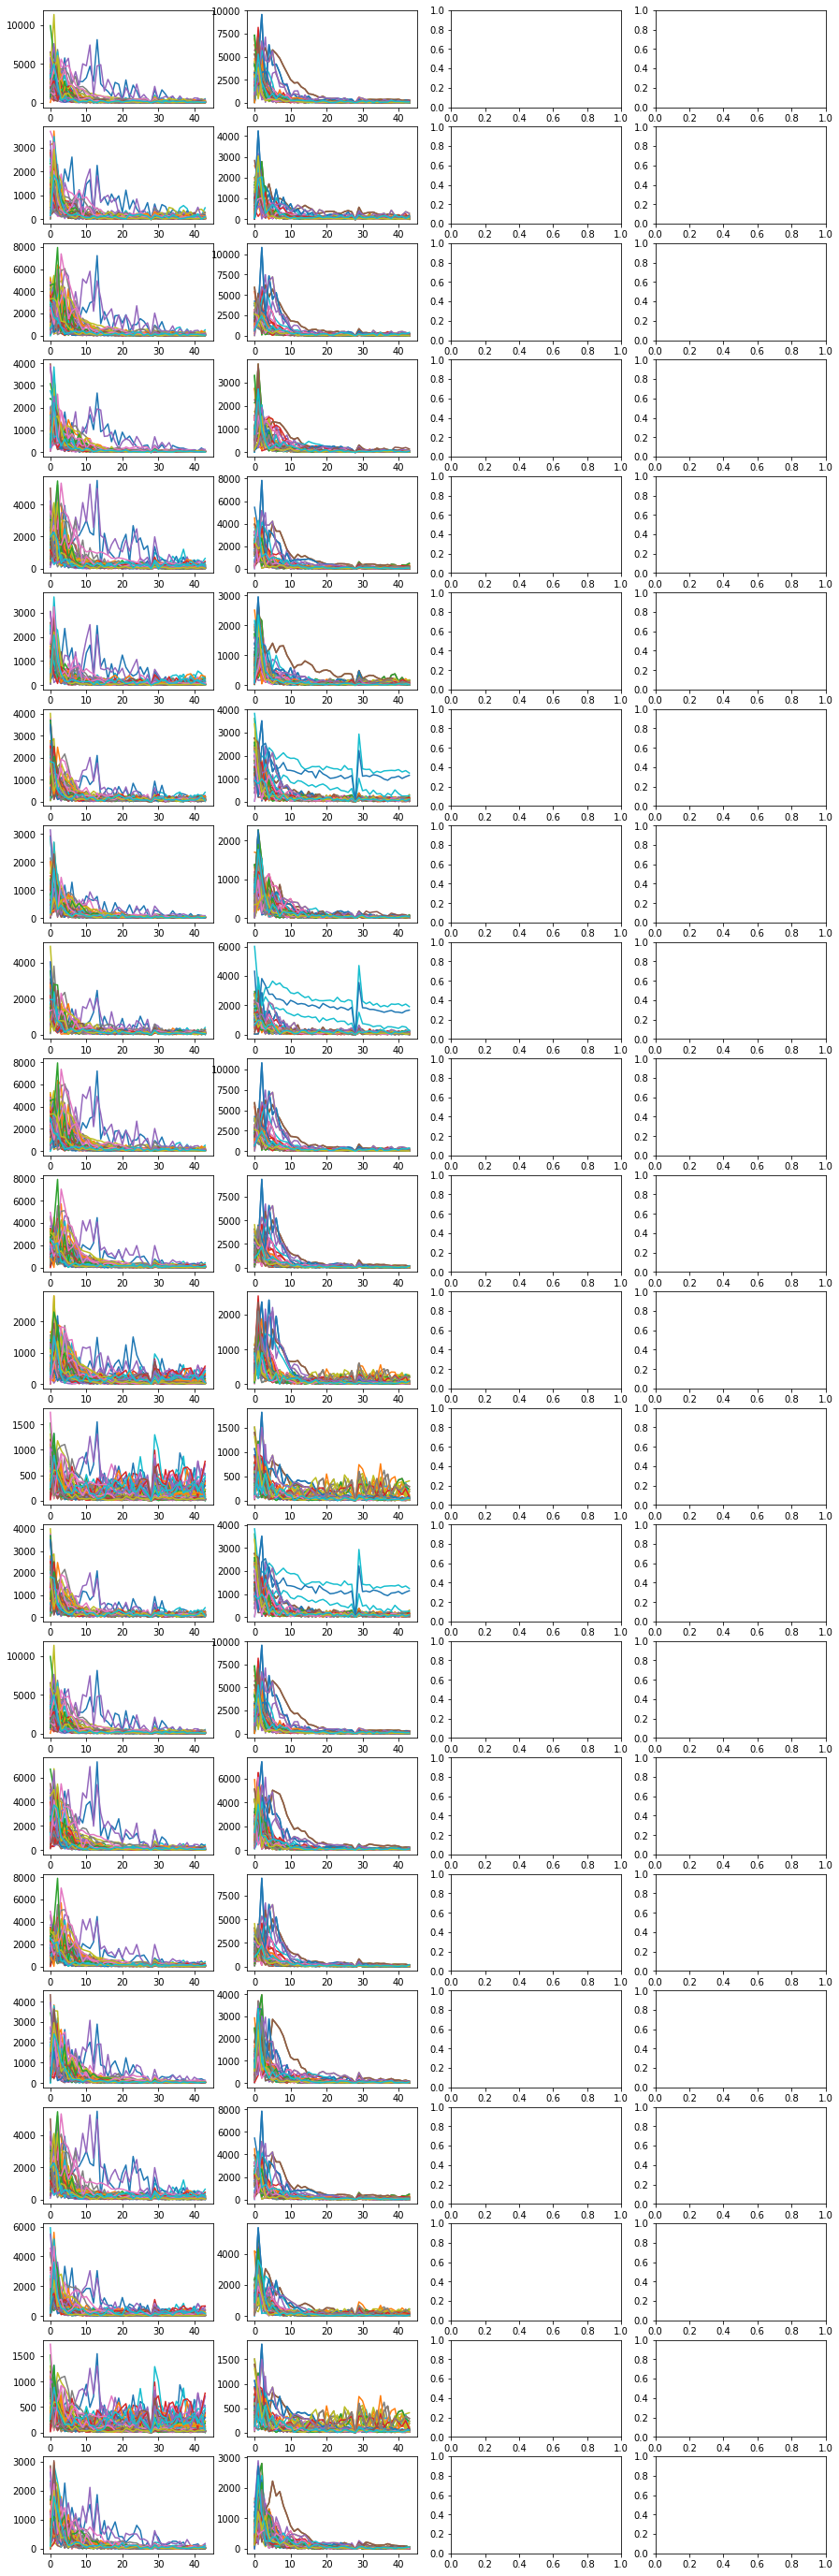

In [229]:
ds_bkg, ds_pre, ds_sez, ds_pos = [], [], [], []
ds_bkg = ds_pwd[locate(labels, LABEL_BKG),:,:]
ds_pre = ds_pwd[locate(labels, LABEL_PRE),:,:]

np.random.seed(0)
rnd_indices = np.random.choice(np.shape(ds_bkg)[0], size=100)
rnd_indices2 = np.random.choice(np.shape(ds_pre)[0], size=100)

explore2D(np.concatenate((ds_bkg[rnd_indices], ds_pre[rnd_indices2])), labels=[LABEL_BKG]*100+[LABEL_PRE]*100)

Looks like we can use the powers of 22 channels to differentiate PRE vs BKG. 
We can compute the AUC to represent the average power. Or, compute the average frequency.

In [10]:
#wrangling to dataframe
ne, nc, ns = np.shape(ds_pwd)
df_pwd = pd.DataFrame(ds_pwd.transpose([0,2,1]).reshape(-1, np.shape(ds_pwd)[1]),
                     columns=['ch'+ str(i) for i in np.arange(0, nc)])

df_pwd = df_pwd.assign(freq=np.tile(np.arange(0, np.shape(ds_pwd)[2]), np.shape(ds_pwd)[0]))\
    .assign(labels = np.repeat(labels, ns))\
    .assign(epoch = np.repeat(np.arange(0, ne), ns))

df_pwd.tail()

,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,...,ch15,ch16,ch17,ch18,ch19,ch20,ch21,freq,labels,epoch
88567,214.440123,125.883290,175.349445,15.372205,109.175661,205.382894,108.721999,22.086772,71.111972,175.349445,...,57.149420,21.700642,41.497151,109.175661,102.721203,37.836804,57.431635,39,post,2012
88568,438.853494,367.680734,273.624317,9.161372,110.075066,167.151668,54.067523,24.896487,168.018209,273.624317,...,110.216756,47.824699,66.133381,110.075066,298.121557,31.714240,70.902752,40,post,2012
88569,317.872513,282.091258,135.709215,29.384350,231.285558,127.879420,222.663593,33.124313,72.052119,135.709215,...,92.706102,60.695819,3.395686,231.285558,65.432775,161.821229,50.738249,41,post,2012
88570,174.193325,135.733080,180.537980,15.332499,213.185756,148.370065,197.854742,25.452137,120.913044,180.537980,...,56.566075,47.851915,36.701423,213.185756,199.749814,75.452453,22.198453,42,post,2012
88571,19.231124,43.329401,47.666062,21.997170,57.840527,144.328054,151.848062,7.009163,120.728119,47.666062,...,18.145547,20.968695,39.221749,57.840527,163.638709,106.801699,56.566752,43,post,2012


### compute the power of each channel.


In [11]:
dfpwd = pd.wide_to_long(df_pwd, ['ch'], ['freq', 'labels', 'epoch'], 'channel')

In [12]:
res = []
for name, group in dfpwd.groupby(['epoch', 'channel']):    
    ng = group.reset_index()\
        .assign(pwd = lambda x: np.mean(x.ch),
                freqs = lambda x: np.sum(x.freq * x.ch/np.sum(x.ch)))\
        .drop(['ch', 'freq'], 'columns')\
        .drop_duplicates(['epoch', 'channel'])
    res.append(ng)
dfpwd2 = pd.concat(res)

del res, ng, dfpwd
dfpwd2.head()
# you can assign and drop in one call

,labels,epoch,channel,pwd,freqs
0,pres,0,0,401.084357,6.015862
0,pres,0,1,157.662515,8.840141
0,pres,0,2,275.373087,8.849204
0,pres,0,3,137.341455,6.537523
0,pres,0,4,218.338927,7.347053


In [202]:
Xy = dfpwd2.pivot(index='epoch', columns='channel', values=['pwd', 'freqs'])\
    .assign(label = labels).to_numpy()

In [203]:
Xy[0]

array([401.08435709890415, 157.66251464661718, 275.37308737596146,
       137.34145526387152, 218.33892703405502, 127.90236986741319,
       163.07215185871445, 90.69962469696543, 210.85478388699903,
       275.37308737596146, 183.86717605629715, 88.82477865552859,
       67.11367170727884, 163.07215185871445, 401.08435709890415,
       292.5019243514329, 183.86717605629715, 147.33531706412074,
       218.33892703405502, 168.3393471470215, 67.11367170727884,
       113.36395834856408, 6.015862061096481, 8.840140566891309,
       8.849203677991467, 6.537523245323344, 7.347053188632315,
       8.762575958860594, 13.503818673728306, 10.004054343195277,
       12.456808920916627, 8.849203677991467, 8.088919810525706,
       7.430269346561628, 10.554666993210736, 13.503818673728306,
       6.015862061096481, 5.830713235351547, 8.088919810525706,
       6.7922095205402995, 7.347053188632315, 6.714447720216471,
       10.554666993210736, 8.02246351632143, 'pres'], dtype=object)

### simple classifier

#### pre-processing

In [204]:
from sklearn import preprocessing

Xy[id_bkg_pre,:-1].shape
X = Xy[id_bkg_pre, :-1]
y = Xy[id_bkg_pre, -1]

In [205]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier

In [206]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
    test_size=0.2,
    random_state=41)

In [207]:
np.shape(train_X), test_X.shape

((792, 44), (198, 44))

In [208]:
clf = RandomForestClassifier(n_estimators=20, max_depth=None,
    min_samples_split=2, random_state=0)

scores = cross_val_score(clf, train_X, train_y, cv=5)

scores.mean()

0.8674150147281268

In [209]:
clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [210]:
clf.score(test_X, test_y)

0.8888888888888888

In [211]:
# presist trained model
import pickle
with open('model.pkl', 'wb') as fp:
    pickle.dump(clf, fp)
with open('model.pkl', 'rb') as fp:
    clf = pickle.load(fp)
# clf.predict(test_X[0, :]), test_y[0]

## save a couple txt files for demo

In [212]:
eval_X = Xy[id_pre, :-1]
eval_y = Xy[id_pre, -1]
clf.predict(eval_X)

array(['bckg', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'bckg',
       'bckg', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres',
       'pres', 'pres', 'pres', 'pres', 'bckg', 'pres', 'bckg', 'pres',
       'bckg', 'pres', 'pres', 'pres', 'bckg', 'pres', 'pres', 'pres',
       'pres', 'bckg', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres',
       'pres', 'bckg', 'pres', 'pres', 'pres', 'pres', 'bckg', 'pres',
       'pres', 'pres', 'pres', 'pres', 'pres', 'bckg', 'bckg', 'bckg',
       'pres', 'pres', 'pres', 'bckg', 'pres', 'pres', 'pres', 'pres',
       'pres', 'pres', 'pres', 'bckg', 'pres', 'pres', 'pres', 'pres',
       'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres',
       'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres', 'pres',
       'pres', 'pres', 'pres', 'bckg', 'pres', 'bckg', 'bckg', 'pres',
       'pres', 'pres', 'bckg', 'pres', 'bckg', 'pres', 'bckg', 'pres',
       'pres', 'pres', 'bckg', 'pres', 'pres', 'pres', 'pres', 'bckg',
      

In [213]:
for i in range(1, 4):
    with open('./svdemo-pre-'+str(i)+'.txt', 'wb') as fp1:
        np.savetxt(fp1, dataset[np.where(id_pre)[0][i]], delimiter=',')
    with open('./svdemo-bkg-'+str(i)+'.txt', 'wb') as fp1:
        np.savetxt(fp1, dataset[np.where(id_bkg)[0][i]], delimiter=',')
    

In [214]:
import model
x = model.bin_power_avg([np.loadtxt('svdemo-pre-2.txt', delimiter=',')], 400)
x,  Xy[np.where(id_pre)[0][2], :]

(array([[   0.        , 1553.86974743,  518.08982561, 1391.72323479,
          434.38597515, 1114.49448949,  595.87552909,  448.32422422,
          261.88248419,  434.65491528, 1391.72323479, 1158.5869697 ,
          385.48647919,  241.16966532,  448.32422422, 1553.86974743,
         1422.45125294, 1158.5869697 ,  733.02428348, 1114.49448949,
          688.15398898,  241.16966532,  519.55390807,    8.89066934,
           13.54404164,    9.44715931,    9.67772252,   10.28007077,
           12.71863968,    9.00584102,    8.46814574,   11.20272549,
            9.44715931,    9.49717649,    8.96973688,    8.75336518,
            9.00584102,    8.89066934,    9.8004106 ,    9.49717649,
            9.07783612,   10.28007077,   10.72077237,    8.75336518,
            9.59849499]]),
 array([1553.869747430321, 518.0898256059808, 1391.7232347856507,
        434.38597514782776, 1114.4944894888374, 595.8755290906768,
        448.32422421708617, 261.88248418907443, 434.654915277443,
        1391.72

In [201]:
np.shape(np.array(dataset))

(2013, 22, 400)

## Try MNE
https://cbrnr.github.io/2017/10/23/loading-eeg-data/


In [44]:
import mne
import os
mne.__version__

'0.20.5'

In [49]:
train_path = '../tusz_1_5_2/edf/train'
tcp_type = '01_tcp_ar'
patient_group = '023'
patient = '00002348'
session = 's008_2015_07_21'
token = '00002348_s008_t000'
token_path = os.path.join(train_path, tcp_type, patient_group, patient, session, token)
raw = mne.io.read_raw_edf(token_path+'.edf', preload=False)

Extracting EDF parameters from /Users/yanxlin/github/ids/tusz_1_5_2/edf/train/01_tcp_ar/023/00002348/s008_2015_07_21/00002348_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [47]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 29 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2015-07-21 10:26:07 UTC
 nchan: 29
 projs: []
 sfreq: 256.0 Hz
>

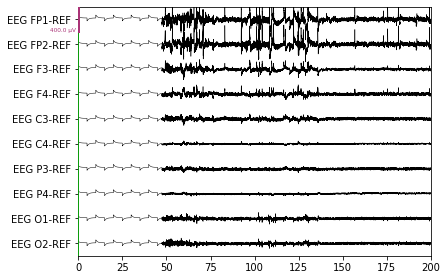

In [48]:
raw.plot(duration=200, n_channels=10, scalings=dict(eeg=20e-5), show_scrollbars=False)
plt.close()